## Logistic regression

We want to minimize
$$\min_{x\in {\mathbb R}^{d}} f(x)=-\frac{1}{n}\sum_{i=1}^n \left(y_i \log (s(a_i^\top x)) + (1 - y_i) \log (1 - s(a_i^\top x))\right) + \frac{\ell_2}{2}\|x\|^2,$$
where  $a_i\in {\mathbb R}^{d}$, $y_i\in \{0, 1\}$, $s(z)=\frac{1}{1+\exp(-z)}$ is the sigmoid function.
The gradient is given by $\nabla f(x) = \frac{1}{n}\sum_{i=1}^n a_i(s(a_i^\top x)-y_i) + \ell_2 x$.

This is a smooth function with smoothness constant $L=\frac{1}{4}\lambda_{\max}(X^\top X) + \ell_2$, where $\lambda_{\max}$ denotes the largest eigenvalue.

For this experiment we used mushrooms and covtype datasets from the LibSVM library. Since the former is smaller and hence runs faster, we use it below.

In [1]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.datasets import load_svmlight_file

from optimizers import Gd, Nesterov, Ad_grad, Ad_grad_accel, Adagrad

sns.set(style="whitegrid", context="talk", palette=sns.color_palette("bright"), color_codes=False)
data_path = './datasets/mushrooms'
markers = [',', 'o', '*', '^', 'D', 's']
labels = ['GD', 'Nesterov', 'AdGD', 'AdGD-L', 'AdGD-accel', 'Adagrad']

it_max = 3000

def logistic_smoothness(X):
    return 0.25 * np.max(la.eigvalsh(X.T @ X / X.shape[0]))


data = load_svmlight_file(data_path)
X, y = data[0].toarray(), data[1]
if (np.unique(y) == [1, 2]).all():
    y -= 1
n, d = X.shape
L = logistic_smoothness(X)
l2 = L / (10 * n)
w0 = np.zeros(d)

In [2]:
gd = Gd(it_max=it_max)
gd.run(w0=np.zeros(d), X=X, y=y, l2=l2)

In [3]:
nest = Nesterov(it_max=it_max)
nest.run(w0=np.zeros(d), X=X, y=y, l2=l2)

In [4]:
adgd = Ad_grad(eps=0, it_max=it_max)
adgd.run(w0=np.zeros(d), X=X, y=y, l2=l2)

In [5]:
adgdl = Ad_grad(eps=1 / L ** 2, it_max=it_max)
adgdl.run(w0=np.zeros(d), X=X, y=y, l2=l2)

In [6]:
ad_acc = Ad_grad_accel(it_max=it_max)
ad_acc.run(w0=np.zeros(d), X=X, y=y, l2=l2)

In [7]:
adagrad = Adagrad(it_max=it_max)
adagrad.run(w0=np.zeros(d), X=X, y=y, l2=l2)

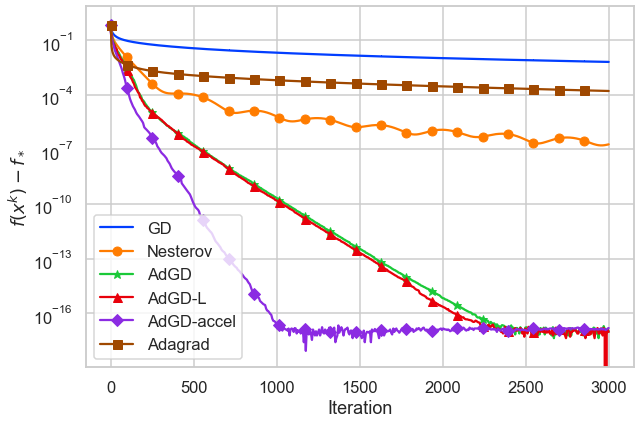

In [8]:
optimizers = [gd, nest, adgd, adgdl, ad_acc, adagrad]
for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
f_star = np.min([np.min(opt.losses) for opt in optimizers])

plt.figure(figsize=(9, 6))
for opt, marker, label in zip(optimizers, markers, labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend()
plt.tight_layout()
plt.show()